In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import dice_coef, ss_metric, compute_metric
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Brown => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.000001
opt = tf.keras.optimizers.Adam(lr)
ver = 'AttUnet_02' #save version 
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/HGG/'

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool, attention_block
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply

def AttUnet_model(input_layer, attention_mode='grid'):
    #downsampling path
    conv1 = conv_block(input_layer, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn, dropout_rate = dropout)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn, dropout_rate = dropout)
    
    #upsampling path
    att01 = attention_block(conv4, conv5, 512)
    up1 = up(conv5,filters=512, merge=att01, kernel_initializer=hn)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att02 = attention_block(conv3, conv6, 256)
    else:
        att02 = attention_block(conv3, conv4, 256)
    up2 = up(conv6, filters=256, merge=att02, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att03 = attention_block(conv2, conv7, 128)
    else:
        att03 = attention_block(conv2, conv3, 128)
    up3 = up(conv7, filters=128, merge=att03, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att04 = attention_block(conv1, conv8, 64)
    else:
        att04 = attention_block(conv1, conv2, 64)
    up4 = up(conv8, filters=64, merge=att04, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    return output_layer

In [5]:
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, AttUnet_model(input_layer))

In [6]:

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image)
        loss = generalized_dice_loss(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients


Epochs  1



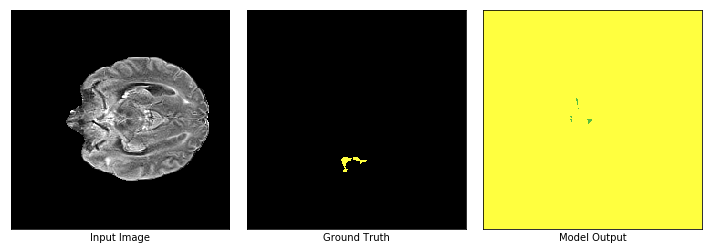

Steps: 1000, Loss:0.9777860045433044
Accurary: 0.00251736119389534
Dice coefficient: [2.631578e-07, 2.631578e-07, 0.0050220797]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9993402777778924, 0.9993402777778924, 1.7404925590913772e-10]
Gradient min:-0.000789827958215028, max:0.0008570335921831429


In [ ]:
epochs = 1
max_epochs = 30
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%1000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [ ]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [ ]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def val_fn(image, label):
    model.trainable = False
    model_output = model(image)
    loss = xent(label, model_output)
    return model_output, loss

In [ ]:
tfrecords_val = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/LGG/'

steps = 1
acc_list = []
for tf_re in sorted(os.listdir(tfrecords_val)):
    tf_dir = os.path.join(tfrecords_val+tf_re)
    dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    dc_app = []
    sens_app = []
    spec_app = []
    for imgs in dataset:
        image = imgs[:,:,:,:4]
        label = imgs[:,:,:,-1]
        label = tf.where(label==4,3,label)
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        img_seg, loss = val_fn(image, label) #validation function 
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        dc_list, sens_list, spec_list =compute_metric(label,img_seg)
        #append
        acc_list.append(acc)
        dc_app.append(dc_list)
        sens_app.append(sens_list)
        spec_app.append(spec_list)
        #output
        if steps%100==0:
#             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
            dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            print("Steps: {}, Loss:{}".format(steps, loss))
            print("Accuracy: {}".format(acc_stp))
            print("Dice coefficient: {}".format(dc_list))
            print("Sensitivity: {}".format(sens_list))
            print("Specificity: {}".format(spec_list))
        steps+=1
    mean_dc = np.mean(np.array(dc_app),0)
    mean_sens = np.mean(np.array(sens_app),0)
    mean_spec = np.mean(np.array(spec_app),0)
    print("Mean Accuracy: {}".format(np.mean(acc_list)))
    print("Mean Dice coefficient: {}".format(mean_dc))
    print("Mean Sensitivity: {}".format(mean_sens))
    print("Mean Specificity: {}".format(mean_spec))

---

# Model Summary

In [ ]:
model.summary()